**IMAGE REGISTRATION -- DEMONS ALGORITHM**

In [12]:
import cv2
import numpy as np
import SimpleITK as sitk
import os

import sitk_files.registration_utilities as ru
import sitk_files.registration_callbacks as rc

%matplotlib inline
import matplotlib.pyplot as plt


from demons_algorithm import *

import os

In [105]:
## CREATE FIXED AND MOVING IMAGES for a given subject and eye ##

moving_images = []
moving_images_path = []
segs = []
points = []
descriptors = []
IoUs = []

i = 66
dir = '/Users/maria/Documents/GitHub/TFM/OCTA_time_series/GRAPH_matching/data/soul_longitudinal/soul_imgs_jpg/' 
img_path = os.path.join(dir, f'{i}_16508.jpg')
moving_img_path = os.path.join(dir, f'{i}_16486.jpg')

original_img = cv2.imread(img_path)
img_cv2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
moving_img_cv2 = cv2.imread(moving_img_path, cv2.IMREAD_GRAYSCALE)
_, thresholded_img = cv2.threshold(img_cv2,75, 255, cv2.THRESH_BINARY)  # Adjust threshold value as needed

fixed_image = sitk.ReadImage(img_path, sitk.sitkFloat64)
threshold = thresholded_img
moving_image = sitk.ReadImage(moving_img_path, sitk.sitkFloat64)


orb = cv2.ORB_create()
kp, des = orb.detectAndCompute(img_cv2, threshold) ## IM USING AS MASK THE THREHSOLDED IMG FROM THE FIXED IMAGE   
keypoints = [kp_i.pt for kp_i in kp]
fixed_points = keypoints
fixed_descriptors = des

orb = cv2.ORB_create()
kp_mov, des_mov = orb.detectAndCompute(moving_img_cv2, threshold) ## IM USING AS MASK THE THREHSOLDED IMG FROM THE FIXED IMAGE   
keypoints_mov = [kp_i.pt for kp_i in kp_mov]
moving_points = keypoints_mov
moving_descriptors = des_mov
    

40: 3276.20(170.0, 122.0)
(170.0, 122.0)

Initial alignment errors in millimeters, mean(std): 119.39(58.61), max: 273.36
Final alignment errors in millimeters, mean(std): 119.01(57.93), max: 272.67


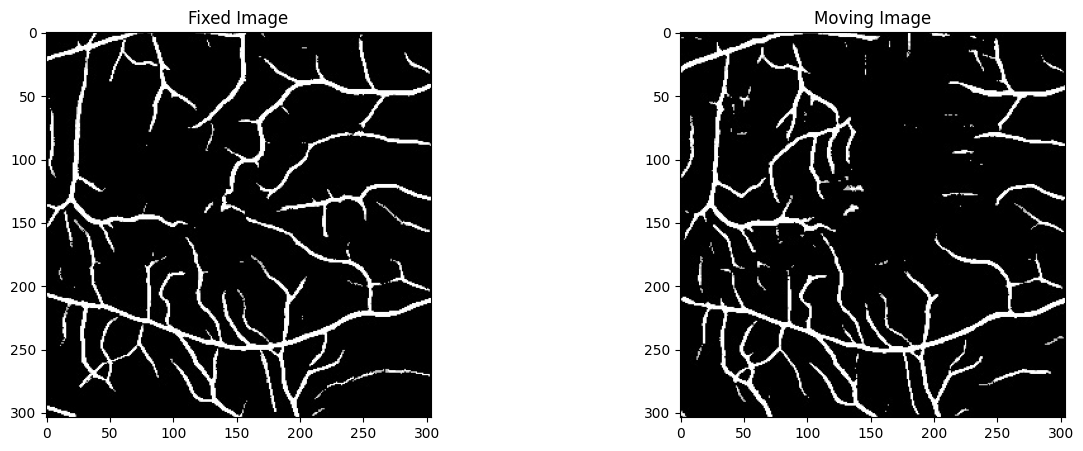

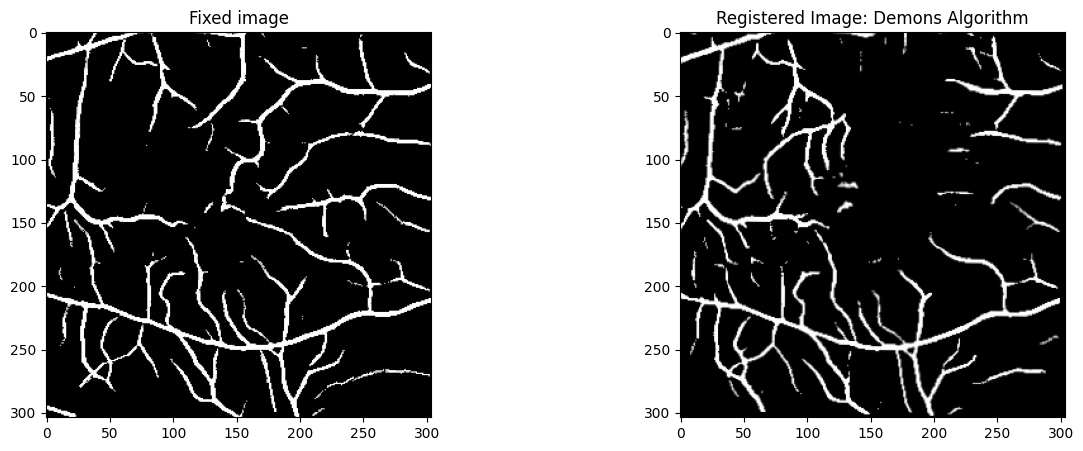

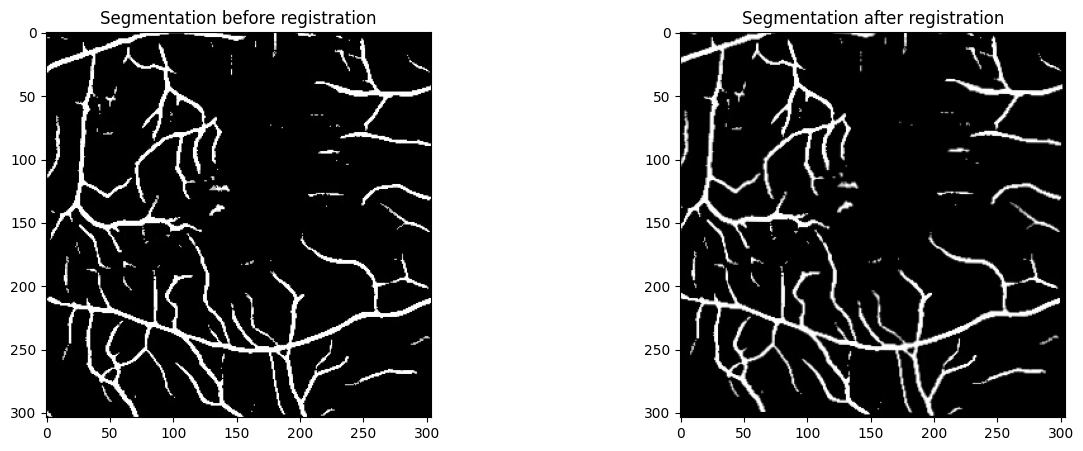

In [106]:
# Define a simple callback which allows us to monitor the Demons filter's progress.
def iteration_callback(filter):
    print('\r{0}: {1:.2f}'.format(filter.GetElapsedIterations(), filter.GetMetric()), end='')
    
# Select a Demons filter and configure it.
demons_filter =  sitk.FastSymmetricForcesDemonsRegistrationFilter()
demons_filter.SetNumberOfIterations(40)
# Regularization (update field - viscous, total field - elastic).
demons_filter.SetSmoothDisplacementField(True)
demons_filter.SetStandardDeviations(10.0)

# Add our simple callback to the registration filter.
demons_filter.AddCommand(sitk.sitkIterationEvent, lambda: iteration_callback(demons_filter))

# Run the registration.
tx = multiscale_demons(registration_algorithm=demons_filter, 
                    fixed_image = fixed_image, 
                    moving_image = moving_image,
                    initial_transform=sitk.Euler2DTransform(),
                    shrink_factors = [4,2],
                    smoothing_sigmas = [8,4])


# Compare the initial and final TREs.
identity_transform = sitk.Euler2DTransform()
identity_transform.SetIdentity()
initial_errors_mean, initial_errors_std, _, initial_errors_max, initial_errors = ru.registration_errors(identity_transform, fixed_points, moving_points)
final_errors_mean, final_errors_std, _, final_errors_max, final_errors = ru.registration_errors(tx, fixed_points, moving_points)

print('\nInitial alignment errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(initial_errors_mean, initial_errors_std, initial_errors_max))
print('Final alignment errors in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(final_errors_mean, final_errors_std, final_errors_max))


registered_image_withTx = sitk.Resample(moving_image, fixed_image, tx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
"""print(sitk.GetArrayFromImage(moving_image).shape)
print(segs[i].shape)    
print(fixed_seg.shape)"""
registered_seg_withTx = sitk.Resample(sitk.GetImageFromArray(moving_img_cv2), sitk.GetImageFromArray(img_cv2), tx, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

img = sitk.GetArrayFromImage(registered_image_withTx)
seg = sitk.GetArrayFromImage(registered_seg_withTx)

# Save the registered image as a JPG file
out_dir = '/Users/maria/Documents/GitHub/TFM/OCTA_time_series/GRAPH_matching/data/soul_longitudinal/'
output_image_path = os.path.join(out_dir, f'fixed_soul_imgs_jpg/{i}.jpg')
output_registered_path = os.path.join(out_dir, f'registered_soul_imgs_jpg/{i}.jpg')

# Convert the registered image and segmentation to the format needed for saving
sitk.WriteImage(sitk.Cast(fixed_image, sitk.sitkUInt8), output_image_path)
sitk.WriteImage(sitk.Cast(registered_image_withTx, sitk.sitkUInt8), output_registered_path)



# Display the results.
# Display the fixed, moving, and registered images
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the fixed image
axes[0].imshow(sitk.GetArrayFromImage(fixed_image), cmap='gray')
axes[0].set_title('Fixed Image')
axes[0].axis('on')

# Plot the moving image
axes[1].imshow(sitk.GetArrayFromImage(moving_image), cmap='gray')
axes[1].set_title('Moving Image')
axes[1].axis('on')

plt.show()


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Plot the registered image
axes[0].imshow(sitk.GetArrayFromImage(fixed_image), cmap='gray')
axes[0].set_title('Fixed image')
axes[0].axis('on')

axes[1].imshow(sitk.GetArrayFromImage(registered_image_withTx), cmap='gray')
axes[1].set_title('Registered Image: Demons Algorithm')
axes[1].axis('on')

plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Plot the registered image
axes[0].imshow(moving_img_cv2, cmap='gray')
axes[0].set_title('Segmentation before registration')
axes[0].axis('on')

axes[1].imshow(seg, cmap='gray')
axes[1].set_title('Segmentation after registration')
axes[1].axis('on')

plt.show()